# Deep Learning 2023 - Neural Networks

#### Environment
Python 3, Numpy, matplotlib, sklearn

#### Dataset
* [**Fashion-MNIST**](https://github.com/zalandoresearch/fashion-mnist)
is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. Using the Fashion-MNIST give you more room to wiggle your experiments.


## Part 1. Import Libraries, Loading and Preprocessing the Training and Testing Data

In [1]:
# You will mainly use numpy to construct your NN
import numpy as np
import matplotlib, time, copy, os, requests, zipfile, sys
# Matplotlib to plot the image
import matplotlib.pyplot as plt
# Off-the-shelf evaluation functions provided by sklearn
from sklearn.metrics import confusion_matrix, accuracy_score

### Functions use to download the dataset from OneDrive
Here we use the [onedrivedownloader](https://pypi.org/project/onedrivedownloader/) package for data download.

In [2]:
!pip install onedrivedownloader

In [3]:
from onedrivedownloader import download

link = 'https://unioulu-my.sharepoint.com/:u:/g/personal/hliu22_univ_yo_oulu_fi/EW3HQP_PhE9GpXBS50bADNIBzmmQX2lBpaEp-9mWhpPrsA?e=auRurQ'

if not os.path.exists('./data_hw2/fashion_mnist_npy'):
    print('Downloading dataset')
    download(link, filename="./fashion_mnist_npy.zip", unzip=True, unzip_path='./data_hw2/fashion_mnist_npy')

100%|██████████| 30.6M/30.6M [00:00<00:00, 41.1MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 4/4 [00:00<00:00, 14.72it/s]


### Functions use to pre-process your training/testing data

In [4]:
def reshape_train_data(X):
    ''' Input training data has shape (60000, 28, 28)
        Input testing data has shape (10000, 28, 28)
        where: 
        60000 is the numbers of input training samples
        10000 is the numbers of input testing samples
        similar to MNIST, resolution of each sample is 28 x 28
    '''
    samples, H, W = X.shape
    # Reshape input volume to (sample, 784), this mean, your NN input layer will have 784 placeholders
    # we scale the RGB values by divide them by 255, this will help improve the training performance
    return X.reshape(samples, H * W).T / 255

def one_hot_vector(x, num_classes):
    # By now, I think you already heard about this so many times
    return np.eye(num_classes)[x].T

### Finally, we load and preprocess the data

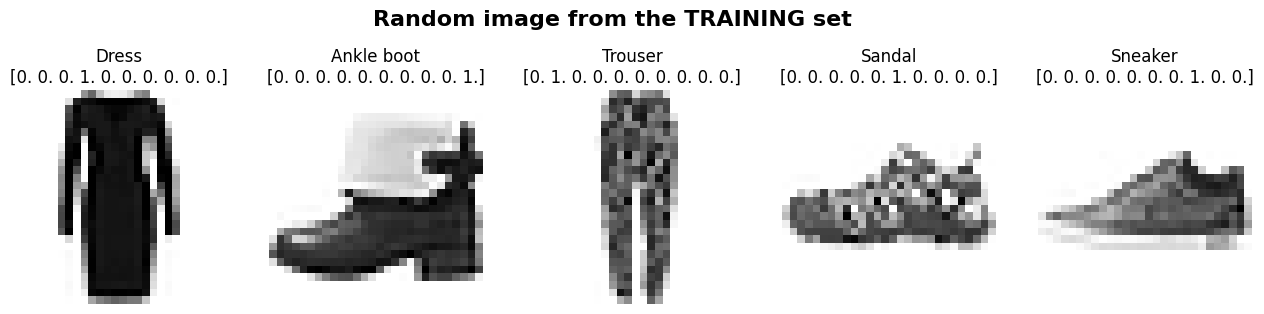

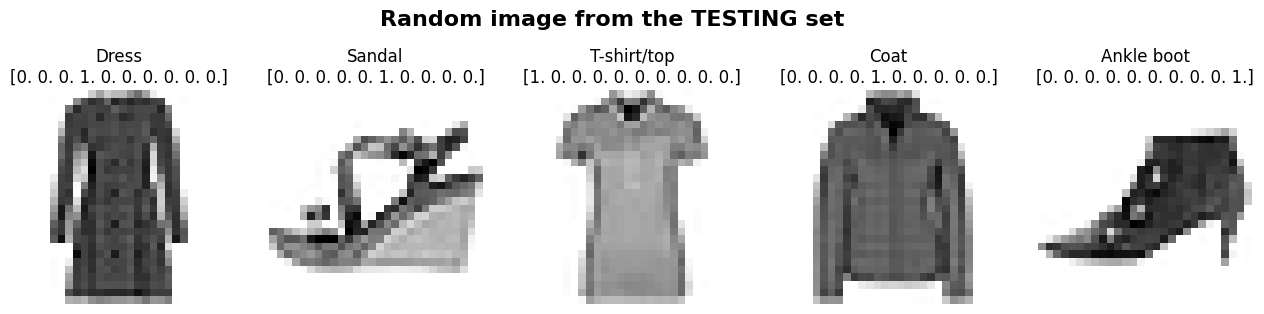

In [5]:
PATH = os.path.join('data_hw2', 'fashion_mnist_npy')

# The actual meaning of the label of your classes.
# E.g. if an output one-hot vector is [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], it used to prepresent a Dress
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Load the training input
X_train = np.load(os.path.join(PATH, 'train_data.npy'))
# Load the training labels
X_test = np.load(os.path.join(PATH, 'test_data.npy'))
# Load the testing input
Y_train = np.load(os.path.join(PATH, 'train_labels.npy'))
# Load the testing labels
Y_test = np.load(os.path.join(PATH, 'test_labels.npy'))

# Get the number of classes
num_classes = len(label_names)
# Get the number of training samples and their resolution for reshape
num_trains, HEIGHT, WIDTH = X_train.shape

# Reshape the training and testing inputs
X_train, X_test = reshape_train_data(X_train), reshape_train_data(X_test)

# Create one-hot vector for the training and testing labels
Y_train, Y_test = one_hot_vector(Y_train, num_classes), one_hot_vector(Y_test, num_classes)

# This part use to randomly load some of the training and testing image and the one-hot vectors for checking
fig_train, ax_train = plt.subplots(figsize=(16, 8), nrows=1, ncols=5)
fig_train.suptitle("Random image from the TRAINING set", y=0.73, fontsize=16, fontweight='bold')

fig_test, ax_test = plt.subplots(figsize=(16, 8), nrows=1, ncols=5)
fig_test.suptitle("Random image from the TESTING set", y=0.73, fontsize=16, fontweight='bold')

for idx in range(5):
    i, j = np.random.randint(num_trains), np.random.randint(X_test.shape[0])
    
    ax_train[idx].imshow(X_train[:,i].reshape(HEIGHT, WIDTH), cmap = matplotlib.cm.binary)
    ax_train[idx].set_title(label_names[np.argmax(Y_train[:,i])] + "\n" + str(Y_train[:,i]))
    ax_train[idx].axis('off')
    
    ax_test[idx].imshow(X_test[:,j].reshape(HEIGHT, WIDTH), cmap = matplotlib.cm.binary)
    ax_test[idx].set_title(label_names[np.argmax(Y_test[:,j])] + "\n" + str(Y_test[:,j]))
    ax_test[idx].axis('off')

## Part 2. Build the Neural Network, Forward and Backward Propagation (<span style="color:green">9.5 points</span>)



In [6]:
print('Shape of X_train:', X_train.shape)
print('Shape of Y_train:', Y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of Y_test:', Y_test.shape)

Shape of X_train: (784, 60000)
Shape of Y_train: (10, 60000)
Shape of X_test: (784, 10000)
Shape of Y_test: (10, 10000)


In [7]:
# Numbers of input units
num_inputs = X_train.shape[0]

# Number of neural in your hidden layer
num_hidden_1 = 9
num_hidden_2 = 3

# Numbers of output units
num_outputs = num_classes

In [8]:
def init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs):
    """Method for initialize the model parameters and the learning velocity of momentum for SGD.

    Returns:
        parameters (tuple): The model parameters: W1, W2, W3
        velocity (tuple): The learning velocity of momentum: V_dW1, V_dW2, V_dW3
    """

    # Construct your neural network in Fig. 2 
    # TODO: Random initialize the hidden_1, hidden_2 and output layer weights (w/o bias) (1 point)
    # Hints: use np.random.randn()
    W1 = np.random.randn(num_hidden_1, num_inputs)
    W2 = np.random.randn(num_hidden_2, num_hidden_1)
    W3 = np.random.randn(num_outputs, num_hidden_2)

    parameters = W1, W2, W3

    # Zeros initialize the momentum for SGD
    V_dW1 = np.zeros(W1.shape)
    V_dW2 = np.zeros(W2.shape)
    V_dW3 = np.zeros(W3.shape)

    velocity = V_dW1, V_dW2, V_dW3

    return parameters, velocity

In [9]:
parameters, velocity = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)

W1, W2, W3 = parameters

print('Shape of W1:', W1.shape)
print('Shape of W2:', W2.shape)
print('Shape of W3:', W3.shape)

Shape of W1: (9, 784)
Shape of W2: (3, 9)
Shape of W3: (10, 3)


In [10]:
def sigmoid(X):
    # TODO: implement Eq. 1 (1 point)
    # Hints: use np.exp()
    sigmd = 1 / (1 + np.exp(-X))
    return sigmd

def relu(X):
    # TODO: implement Eq. 2 (1 point)
    # Hints: use np.maximum()
    rlu = np.maximum(0, X)
    return rlu

def softmax(X):
    # TODO: implement Eq. 3 (1 point)
    # Hints: use np.exp() and np.sum(, axis=0) <- beware of the axis
    exp_X = np.exp (X)
    sftmx = exp_X/ np.sum (exp_X, axis=0)
    return sftmx

In [11]:
X = np.array([-1, 0, 2]).reshape(-1, 1)

print('X')
print(X, '\n')

print('sigmoid(x)')
print(sigmoid(X), '\n')

print('relu(x)')
print(relu(X), '\n')

print('softmax(x)')
print(softmax(X))

X
[[-1]
 [ 0]
 [ 2]] 

sigmoid(x)
[[0.26894142]
 [0.5       ]
 [0.88079708]] 

relu(x)
[[0]
 [0]
 [2]] 

softmax(x)
[[0.04201007]
 [0.1141952 ]
 [0.84379473]]


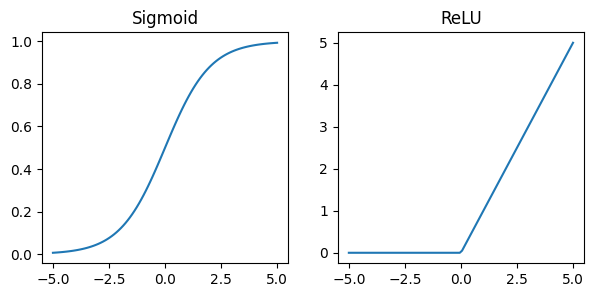

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

x = np.linspace(-5, 5, 100).reshape(-1, 1)

ax[0].set_title('Sigmoid')
ax[0].plot(x, sigmoid(x))

ax[1].set_title('ReLU')
ax[1].plot(x, relu(x))

In [13]:
def forward_propagation(X, parameters):
    """Method for forward propagation.
    Args:
        X (np.array): Input data
        parameters (tuple): Parameters in the model: W1, W2, W3

    Returns:
        outputs (tuple): The forward propagation outputs: Z1, A1, Z2, A2, Z3, A3
    """

    W1, W2, W3 = parameters
    
    # TODO: implement the forward propagation of Fig. 2 based on Eq. 4 - 9 (1 point)
    # Hints: use np.matmul() to implement matrix multiplication
    Z1 = np.matmul(W1,X)
    A1 = sigmoid(Z1)
    Z2 = np.matmul(W2,A1)
    A2 = relu(Z2)
    Z3 = np.matmul(W3,A2)
    A3 = softmax(Z3)

    outputs = Z1, A1, Z2, A2, Z3, A3
    return outputs

In [14]:
np.random.seed(1)
X = np.random.randn(num_inputs, 2)

parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)
Z1, A1, Z2, A2, Z3, A3 = forward_propagation(X, parameters)

print('Shape of X:', X.shape)
print('Shape of Z1:', Z1.shape)
print('Shape of A1:', A1.shape)
print('Shape of Z2:', Z2.shape)
print('Shape of A2:', A2.shape)
print('Shape of Z3:', Z3.shape)
print('Shape of A3:', A3.shape)

print('\nExample results of A3:')
print(A3)

Shape of X: (784, 2)
Shape of Z1: (9, 2)
Shape of A1: (9, 2)
Shape of Z2: (3, 2)
Shape of A2: (3, 2)
Shape of Z3: (10, 2)
Shape of A3: (10, 2)

Example results of A3:
[[2.46725014e-03 9.30825544e-07]
 [3.31005452e-04 6.34655955e-07]
 [5.99451371e-01 9.95638430e-01]
 [9.09817956e-03 4.04817220e-03]
 [1.65653873e-01 4.63410273e-05]
 [3.01971551e-03 8.33547818e-07]
 [1.36952654e-01 3.46917061e-05]
 [6.84035576e-04 1.15346167e-05]
 [8.23364875e-02 2.18431338e-04]
 [5.42874551e-06 6.05182642e-11]]


In [15]:
def cross_entropy_loss(Y, Y_pred):
    # TODO: implement Eq. 10 (1 point)
    # Hints: use np.sum(), np.multiply() and np.log()
    # At the end, we need to divide by the number of of sample in the training batch e.g. m = Y.shape[1]
    m = Y.shape[1]
    loss = -1 / m * np.sum(np.multiply(Y, np.log(Y_pred)))
    return loss

In [16]:
np.random.seed(1)
Y = one_hot_vector(np.random.randint(1, num_classes, 2), num_classes)
A3 = softmax(np.random.randn(num_classes, 2))

L = cross_entropy_loss(Y, A3)
print('Shape of Y:', Y.shape)
print('Shape of A3:', A3.shape)
print('Loss:', L)

Shape of Y: (10, 2)
Shape of A3: (10, 2)
Loss: 1.4200061694735258


In [17]:
def backward_propagation(X, Y, parameters, outputs):
    """Method for forward propagation.
    Args:
        X (np.array): Input data
        Y (np.array): Ground truth of input data
        parameters (tuple): Parameters in the model: W1, W2, W3
        outputs (tuple): The forward propagation outputs: Z1, A1, Z2, A2, Z3, A3
        
    Returns:
        tuple: The computed gradients: dW1, dW2, dW3     
    """

    m = X.shape[1] # The number of data samples in a mini batch

    W1, W2, W3 = parameters
    Z1, A1, Z2, A2, Z3, A3 = outputs
    
    # TODO: calculate the derivative of L with respect to Z3 and W3 using Eq. 14 - 15 (1 point)
    dZ3 = A3 - Y
    dW3 = 1/m *np.matmul(dZ3, A2.T)

    # TODO: calculate the derivative of L with respect to A2, Z2 and W2 using Eq. 16 - 19 (1 point)
    dA2 = np.matmul(W3.T, dZ3)
#    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dZ2 = np.multiply(dA2, (A2>0).astype(int))
    dW2 = 1/m *np.matmul(dZ2, A1.T)

    # TODO: calculate the derivative of L with respect to A1, Z1 and W1 using Eq. 20 - 23 (1 point)
    dA1 = np.matmul(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.multiply(A1, (1-A1)))
    dW1 = 1 / m * np.matmul(dZ1, X.T)

    return dW1, dW2, dW3

In [18]:
np.random.seed(1)
X = np.random.randn(num_inputs, 2)
Y = np.random.randint(1, num_classes, (2, ))

parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)
outputs = forward_propagation(X, parameters)
dW1, dW2, dW3 = backward_propagation(X, Y, parameters, outputs)

print('Shape of dW3:', dW3.shape)
print('Shape of dW2:', dW2.shape)
print('Shape of dW1:', dW1.shape)

print('\nExample results in dW3:')
print(dW3[:, 0])

print('\nExample results in dW2:')
print(dW2[:, 0])

print('\nExample results in dW1:')
print(dW1[:, 0])

Shape of dW3: (10, 3)
Shape of dW2: (3, 9)
Shape of dW1: (9, 784)

Example results in dW3:
[-11.07686748 -11.18325156 -11.07948311 -11.15090766  -9.30689316
 -11.18940487 -11.18383374 -11.18882248 -10.89794772 -11.14887099]

Example results in dW2:
[ 9.68479859 -5.5846308   4.69322188]

Example results in dW1:
[ 1.41874064e-02 -6.39869875e-01  2.22768707e-09 -8.80866594e-07
  2.06468965e-07  6.32945305e-06 -4.88517422e-10  7.55225226e-11
  4.40379402e-03]


In [19]:
def training_step(X, Y, parameters, velocity, learning_rate, beta, weight_decay_lambda=0.):
    """Method for each training step.
    Args:
        X (np.array): Input data
        Y (np.array): Ground truth of input data
        parameters (tuple): Parameters in the model: W1, W2, W3
        velocity (tuple): The learning velocity of momentum: V_dW1, V_dW2, V_dW3
        learning_rate (float): The learning rate for training
        beta (float): The coefficient to update the learning velocity
        weight_decay_lambda (float): The coefficient of weight decay

    Returns:
        tuple: loss, the updated parameters, the updated velocity
    """

    W1, W2, W3 = parameters

    # The forward propagation
    outputs = forward_propagation(X, parameters)
    A3 = outputs[-1]
    
    # Loss computation and backward propagation
    if weight_decay_lambda == 0.:
        loss = cross_entropy_loss(Y, A3)
        dW1, dW2, dW3 = backward_propagation(X, Y, parameters, outputs)
    else:
        loss = cross_entropy_loss(Y, A3) + weight_decay_loss(parameters, weight_decay_lambda)
        dW1, dW2, dW3 = backward_propagation_with_weight_decay(X, Y, parameters, outputs, weight_decay_lambda)
    
    V_dW1, V_dW2, V_dW3 = velocity
    
    # Updating model parameters
    # TODO: Update the learning velocity using Eq. 28 (1 point)
    V_dW1 = beta * V_dW1 + (1 - beta) * dW1
    V_dW2 = beta * V_dW2 + (1 - beta) * dW2
    V_dW3 = beta * V_dW3 + (1 - beta) * dW3

    # TODO: Update the model weights using Eq. 29 (1 point)    
    W1 = W1 - learning_rate * (dW1 + weight_decay_lambda * W1)
    W2 = W2 - learning_rate * (dW2 + weight_decay_lambda * W2)
    W3 = W3 - learning_rate * (dW3 + weight_decay_lambda * W3)

    parameters = W1, W2, W3
    velocity = V_dW1, V_dW2, V_dW3
    
    return loss, parameters, velocity

In [20]:
def training_model(parameters, velocity, batch_size, epoch, learning_rate, beta, weight_decay_lambda=0.):
    
    # Calculate the number of training iterations base on the number of training samples and your batch size
    num_batchs = num_trains // batch_size
    print('Start training the model:')
    print('Number of training samples: {}'.format(num_trains))
    print('Number of batchs: {}'.format(num_batchs))

    loss_log = [] # Log the training loss
    
    # Training
    for i in range(epoch):    
        start_t = time.time()

        indices = np.random.permutation(num_trains)
        X_train_shuffled, Y_train_shuffled = X_train[:, indices], Y_train[:, indices]

        for j in range(num_batchs):

            # Get mini-batch samples for training
            start_idx, end_idx = j * batch_size, min(j * batch_size + batch_size, X_train.shape[1] - 1)
            X, Y = X_train_shuffled[:, start_idx : end_idx], Y_train_shuffled[:, start_idx : end_idx]

            # Call training_step()
            loss, parameters, velocity = training_step(X, Y, parameters, velocity, learning_rate, beta, weight_decay_lambda)

            loss_log.append(loss)
            if (j > 0 and j % 200 == 0):
                print("[Epoch][Iterations]:[{}/{}][{}/{}], loss: {}".format(i, epoch, j, num_batchs, loss))

        print("=> Epoch {}, elapsed time: {:.2f} seconds".format(i, time.time() - start_t))
    
    plt.title('Training loss:')
    plt.plot(loss_log)
    plt.show()
    
    return parameters

Start training the model:
Number of training samples: 60000
Number of batchs: 468
[Epoch][Iterations]:[0/30][200/468], loss: 2.1236429305550777
[Epoch][Iterations]:[0/30][400/468], loss: 2.1141676877376323
=> Epoch 0, elapsed time: 0.28 seconds
[Epoch][Iterations]:[1/30][200/468], loss: 2.0531117235415324
[Epoch][Iterations]:[1/30][400/468], loss: 2.0367935467865976
=> Epoch 1, elapsed time: 0.26 seconds
[Epoch][Iterations]:[2/30][200/468], loss: 1.9489326514164345
[Epoch][Iterations]:[2/30][400/468], loss: 1.7577554501382893
=> Epoch 2, elapsed time: 0.26 seconds
[Epoch][Iterations]:[3/30][200/468], loss: 1.479992697627413
[Epoch][Iterations]:[3/30][400/468], loss: 1.3377993490446694
=> Epoch 3, elapsed time: 0.25 seconds
[Epoch][Iterations]:[4/30][200/468], loss: 1.2849252589388656
[Epoch][Iterations]:[4/30][400/468], loss: 1.185844118199983
=> Epoch 4, elapsed time: 0.25 seconds
[Epoch][Iterations]:[5/30][200/468], loss: 1.0617090077378881
[Epoch][Iterations]:[5/30][400/468], loss: 

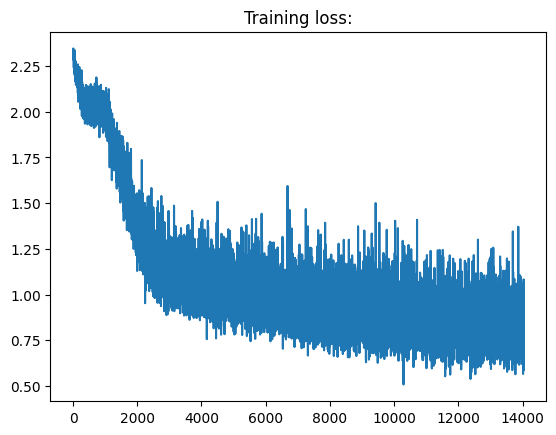

In [21]:
parameters, velocity = init_parameters(
    num_inputs = X_train.shape[0], 
    num_hidden_1 = 9, 
    num_hidden_2 = 3,
    num_outputs = num_classes,
)

trained_parameters = training_model(
    parameters, 
    velocity,
    batch_size = 128,                                     
    epoch = 30,
    learning_rate = 0.25,                                     
    beta = 0.5,                                     
    weight_decay_lambda = 0., 
)

In [22]:
def testing_model(X, parameters):
    # TODO: implement the forward propagation for testing step (0.5 point)
    # Hints: call forward_propagation() function and get the output A3
    A3 = forward_propagation(X, parameters)[-1]

    # Evaluate the performance of your model
    predictions = np.argmax(A3, axis=0)
    labels = np.argmax(Y_test, axis=0)
    
    print("Confusion matrix:\n{}".format(confusion_matrix(labels, predictions)))
    print("Testing accuracy: {}".format(accuracy_score(labels, predictions)))

In [23]:
testing_model(X_test, trained_parameters)

Confusion matrix:
[[763   4   0  98  58   1  67   0   9   0]
 [ 11 926   0  43  14   0   6   0   0   0]
 [ 21   1   0   8 866   0 100   0   4   0]
 [104  48   0 769  20   0  57   0   2   0]
 [ 44  16   0  23 760   0 151   0   6   0]
 [  2   0   0   0   0 783   0 159  22  34]
 [219   4   0  56 470   0 235   0  16   0]
 [  0   0   0   0   0  31   0 903   0  66]
 [  4   1   0   3  76  30   5   3 876   2]
 [  1   1   0   0   0   8   0 105   1 884]]
Testing accuracy: 0.6899


In [24]:
def weight_decay_loss(parameters, lambd):
    """
    Args:
        parameters (tuple): Parameters in the model: W1, W2, W3
        lambd (float): The coefficient of weight decay
        m (float): The number of data samples in a mini batch
    """
    W1, W2, W3 = parameters
    
    # TODO: implement the weight decay loss in Eq. 32 (1 point)
    # Hints: use np.sum() and np.power()
    loss = lambd / 2 * (np.sum(np.power(W1, 2)) + np.sum(np.power(W2, 2)) + np.sum(np.power(W3, 2)))
    return loss

In [25]:
np.random.seed(1)
parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)

loss = weight_decay_loss(parameters, lambd=0.0001)
print('loss:', loss)

loss: 0.35471489737579914


In [26]:
def backward_propagation_with_weight_decay(X, Y, parameters, outputs, lambd):
    """Method for forward propagation.
    Args:
        X (np.array): Input data
        Y (np.array): Ground truth of input data
        parameters (tuple): Parameters in the model: W1, W2, W3
        outputs (tuple): The forward propagation outputs: Z1, A1, Z2, A2, Z3, A3
        lambd (float): The coefficient of weight decay

    Returns:
        tuple: The computed gradients: dW1, dW2, dW3     
    """

    W1, W2, W3 = parameters
    dW1, dW2, dW3 = backward_propagation(X, Y, parameters, outputs)
    
    # TODO: calculate the new derivative of L with respect to W1, W2, and W3 based on Eq. 33 (1 point)
    dW3_new = dW3 + lambd *W3
    dW2_new = dW2 + lambd *W2
    dW1_new = dW1 + lambd *W1

    return dW1_new, dW2_new, dW3_new

In [27]:
np.random.seed(1)
X = np.random.randn(num_inputs, 2)
Y = np.random.randint(1, num_classes, (2, ))

parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)
outputs = forward_propagation(X, parameters)
dW1_new, dW2_new, dW3_new = backward_propagation_with_weight_decay(X, Y, parameters, outputs, lambd=0.0001)

print('\nExample results in dW3 (new):')
print(dW3_new[:, 0])

print('\nExample results in dW2 (new):')
print(dW2_new[:, 0])

print('\nExample results in dW1 (new):')
print(dW1_new[:, 0])


Example results in dW3 (new):
[-11.0768454  -11.18333839 -11.07941469 -11.15094559  -9.30678255
 -11.18963176 -11.1838994  -11.18909476 -10.89788101 -11.14890796]

Example results in dW2 (new):
[ 9.68498668 -5.58462452  4.69335025]

Example results in dW1 (new):
[ 1.42425268e-02 -6.39850968e-01 -1.87264211e-05 -2.81056313e-05
  2.11108273e-04  1.11403812e-04 -3.10541295e-05  4.55282195e-05
  4.47521792e-03]


Start training the model:
Number of training samples: 60000
Number of batchs: 468
[Epoch][Iterations]:[0/30][200/468], loss: 4.91205232754384
[Epoch][Iterations]:[0/30][400/468], loss: 4.2949805071881215
=> Epoch 0, elapsed time: 0.35 seconds
[Epoch][Iterations]:[1/30][200/468], loss: 3.532804536765161
[Epoch][Iterations]:[1/30][400/468], loss: 3.0816388972305644
=> Epoch 1, elapsed time: 0.35 seconds
[Epoch][Iterations]:[2/30][200/468], loss: 2.2228417742872058
[Epoch][Iterations]:[2/30][400/468], loss: 1.9864316613259967
=> Epoch 2, elapsed time: 0.34 seconds
[Epoch][Iterations]:[3/30][200/468], loss: 1.4986913690670265
[Epoch][Iterations]:[3/30][400/468], loss: 1.3749639252014307
=> Epoch 3, elapsed time: 0.34 seconds
[Epoch][Iterations]:[4/30][200/468], loss: 1.2025834948820187
[Epoch][Iterations]:[4/30][400/468], loss: 1.324315183743159
=> Epoch 4, elapsed time: 0.36 seconds
[Epoch][Iterations]:[5/30][200/468], loss: 1.14080295911335
[Epoch][Iterations]:[5/30][400/468], loss: 1.11

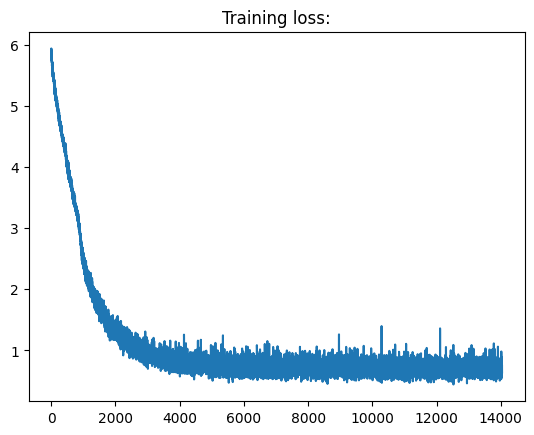

In [28]:
# TODO: adjust the values of hyper-parameters below and try to improve the testing accuracy. (1 point)
# Hints: try to adjust 'num_hidden_2', 'weight_decay_lambda' or other hyper-parameters

parameters, velocity = init_parameters(
    num_inputs = X_train.shape[0], 
    num_hidden_1 = 9, 
    num_hidden_2 = 4,
    num_outputs=num_classes
)

trained_parameters = training_model(
    parameters, 
    velocity,
    batch_size = 128,                                     
    epoch = 30,
    learning_rate = 0.25,                                     
    beta = 0.5,                                     
    weight_decay_lambda = 0.001, 
)

In [29]:
testing_model(X_test, trained_parameters)

Confusion matrix:
[[752   3   9  31  11   0 161   0  33   0]
 [ 15 941   2  20  16   0   4   0   2   0]
 [ 12   0 681   4 160   1 127   0  15   0]
 [126   7   5 748  13   1  85   0  15   0]
 [ 32   0 118   7 746   0  94   0   3   0]
 [  0   0   0   0   0 941   0  40   5  14]
 [139   1 166  14 137   1 501   0  41   0]
 [  0   0   0   0   0  51   0 935   0  14]
 [  1   1   2   8   2  23  33   4 925   1]
 [  0   0   0   0   0  19   0  84   4 893]]
Testing accuracy: 0.8063
